In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import random
from matplotlib import colormaps as cm
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches

# Create directed graph
G = nx.DiGraph()
G.add_nodes_from(range(1, 10))

# Add in different node types
disliked_nodes = [3]
transaction_nodes = [2, 5, 9]
data_nodes = [1, 4, 6, 7, 8]

# Create list of edges
# (parent, child, strength)
edges = [
    (2, 1, 'strong'),  
    (3, 1, 'strong'),
    (4, 1, 'strong'),  
    (4, 2, 'strong'),  
    (5, 3, 'strong'),  
    (5, 4, 'strong'),  
    (6, 3, 'strong'),  
    (6, 4, 'strong'),  
    (7, 4, 'strong'),   
    (7, 6, 'weak'),   
    (8, 2, 'strong'),    
    (8, 4, 'strong'),
    (9, 7, 'strong'),   
]

# Add edges and nodes to graph
for child, parent, ref_type in edges:
    G.add_edge(child, parent, reference=ref_type)

node_type = {}
node_weak = {}

# Initialise all nodes as strong originally
for node in G.nodes:
    node_weak[node] = False

# Check if node is actually weak
# Weak: has a strong connection to a disliked parent node, or if parent node is weak
for node in G.nodes:
    incoming = list(G.in_edges(node, data=True))
    for child, parent, data in incoming:
        if ((parent in disliked_nodes and data['reference'] == 'strong') or node_weak[parent]) and not node_weak[child]:
            node_weak[child] = True
    node_type[node] = 'weak' if node_weak[node] else 'strong'

# Add node positions in 2D
# Evenly distributed in x, for visualisation, and randomly in Y to avoid overlap
random.seed(42)
layer_map = {
    1: 0,
    2: 1, 3: 1,
    4: 2, 5: 2,
    6: 3, 7: 4,
    8: 4, 9: 4
}
pos = {}
for node, layer in layer_map.items():
    x = layer * 2.5
    y = random.uniform(-1, 1)
    pos[node] = (x, y)
nx.set_node_attributes(G, pos, 'pos')


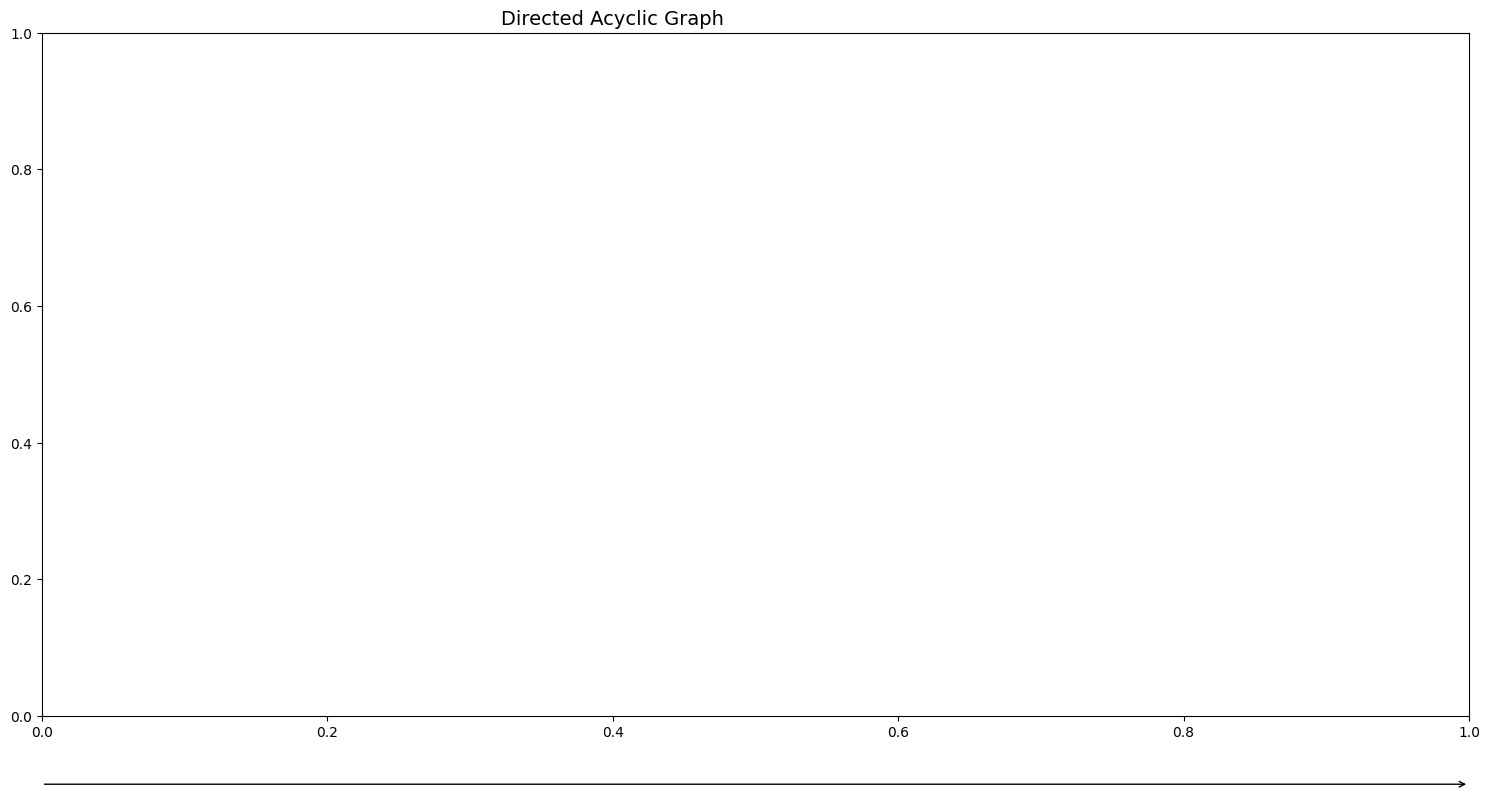

In [ ]:
# Draw plot
fig, ax = plt.subplots(figsize=(15, 8))

# TODO - not working to add time arrow. Adds arrow but removes rest of plot. Might be better in plotly?
# arrow = fig.add_subplot(1,1,1)
# arrow.annotate('', xy=(0,-0.1), xycoords='axes fraction', xytext=(1, -0.1), arrowprops=dict(arrowstyle="<-", color='black'))

# Node degree (number of connections)
degrees = dict(G.degree())
norm = plt.Normalize(vmin=min(degrees.values()), vmax=max(degrees.values()))

# Truncate colour map to avoid bright yellow
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

cmap = truncate_colormap(cm.get_cmap('viridis'), 0.0, 0.7)

# Collect strong and weak nodes separately
strong_nodes = [n for n in G.nodes() if node_type[n] == 'strong']
weak_nodes = [n for n in G.nodes() if node_type[n] == 'weak']

# Build node colours and borders
node_colors = []
node_borders = []

# Set node borders and colours
# Colours relate to node degree
# Borders relate to node type (disliked, transaction or other)
for node in G.nodes():
    degree_norm = norm(degrees[node])
    node_colors.append(cmap(degree_norm))
    
    if node in disliked_nodes:
        node_borders.append('firebrick')
    elif node in transaction_nodes:
        node_borders.append('royalblue')
    else:
        node_borders.append('black')

# Draw strong nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=strong_nodes,
    node_color=[node_colors[n-1] for n in strong_nodes],
    edgecolors=[node_borders[n-1] for n in strong_nodes],
    node_size=800,
    linewidths=3,
    ax=ax
)

# Draw weak nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=weak_nodes,
    node_color=[node_colors[n-1] for n in weak_nodes],
    edgecolors=[node_borders[n-1] for n in weak_nodes],
    node_size=800,
    linewidths=0.1,
    ax=ax
)

# Draw edges
strong_edges = [(u, v) for u, v, d in G.edges(data=True) if d['reference'] == 'strong']
weak_edges = [(u, v) for u, v, d in G.edges(data=True) if d['reference'] == 'weak']

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=strong_edges,
    edge_color='#888',
    arrows=True,
    arrowsize=15,
    width=1,
    connectionstyle="arc3,rad=0.0",
    ax=ax,
    min_source_margin=13,
    min_target_margin=13
)

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=weak_edges,
    edge_color='firebrick',
    style='dotted',
    arrows=True,
    arrowsize=15,
    width=1,
    connectionstyle="arc3,rad=0.0",
    ax=ax,
    min_source_margin=12,
    min_target_margin=12
)

# Node labels
# Shows the node's ID in white
labels = {node: f"{node}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_color='white', ax=ax)

# Add Colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Number of Connections (Degree)')

# Add Legend
legend_elements = [
    mpatches.Patch(facecolor='#eee', edgecolor='gray', label='Data Node'),
    mpatches.Patch(facecolor='#eee', edgecolor='royalblue', label='Transaction Node'),
    mpatches.Patch(facecolor='#eee', edgecolor='firebrick', label='Disliked Node'),
    plt.Line2D([0], [0], color='black', lw=3, linestyle='solid', label='Strong Node'),
    plt.Line2D([0], [0], color='black', lw=0.1, linestyle='solid', label='Weak Node'),
    plt.Line2D([0], [0], color='#888', lw=2, label='Strong Edge'),
    plt.Line2D([0], [0], color='firebrick', lw=2, linestyle='dotted', label='Weak Edge')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='small')

# Show plot
ax.set_title("Directed Acyclic Graph", fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# TODO - add multiple parents structure, think about data format.
# Need to connect to CGS sim
# Need each node to be a data point, either a transaction or a block. Maybe try both?
# Need to find a way to monitor consensus and plot it